In [1]:
import sys 

import xarray as xr
import numpy as np
import pandas as pd

import math

import util

import s3fs
import gcsfs
import boto3

from shapely import geometry

import dask
from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

import cloudpickle
sys.path.append('../analysis/physiology/')
import tpc

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

_PROJECTION = ccrs.Mercator.GOOGLE

In [2]:
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:36639 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 32 Memory: 132.82 GB


# Phytoplankton Thermal Performance and Marine Heatwaves 

Tony Cannistra, 24 Apr 2020

This notebook is a summary of my work examining the performance consequences of marine heatwaves (see Hobday et al., 2016) on phytoplankton. A rich, geographically distributed dataset of modeled phytoplankton growth rate thermal reaction norms from Thomas et al., 2012 is used as the basis for the phytoplankton physiology in this study. I use these data to derive latitudinal models of $T_\mathrm{opt}$, $T_\mathrm{min}$, and $T_\mathrm{max}$, similarly in method to Thomas et al., 2012. 

I employ these latitudinal models to parameterize a general thermal reaction norm function from Deutsch et al., 2008. I apply the resulting function to [NOAA 1/4 degree Optimal Interpolation Sea Surface Temperature](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html) measurements. From these derived performance measures I compute several metrics and assess their relationship them to detected marine heatwaves, their intensity and duration. 

For simplicity, this initial analysis is completed exclusively in the North Pacific. 

The purpose of this notebook is to catalog observations and work thus far (24 Apr 2020). Each of the points above is summarised below.  

## Phytoplankton Dataset + Latitudinal  Reaction Norm Modeling

These data contain a robust set of fitted thermal reaction norms based on empirical measurements of growth rate derived from individual phytoplankton isolates, widely geographically distributed. We filter the data to include only **maritime species** with **good model fits**. The `csv` file below contains the fitted parameters of these curves. 

In [3]:
plankton = pd.read_csv(
    "../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv",
    engine='python'
)

In [4]:
plankton = plankton[
    (plankton.habitat == 'marine') &
    (plankton.curvequal == 'good')
].dropna(subset=['isolation.latitude', 'isolation.longitude'])


In [5]:
plankton.columns

Index(['isolate.code', 'source', 'isolation.latitude', 'isolation.longitude',
       'habitat', 'name', 'speciesname', 'former.name.1', 'former.name.2',
       'strain', 'clone', 'species', 'genus', 'family', 'order', 'class',
       'phylum', 'kingdom', 'domain', 'comment', 'group', 'mu.rsqrlist',
       'mu.wlist', 'mu.alist', 'mu.blist', 'mu.slist', 'mu.c.opt.list',
       'mu.c.opt.val.list', 'mu.g.opt.list', 'mu.g.opt.val.list', 'mu.n',
       'emp.max.growth', 'tmin', 'tmax', 'minqual', 'maxqual', 'curvequal',
       'abs.curveskew', 'rel.curveskew', 'used.for.optimum.analysis',
       'used.for.tmax.analysis', 'used.for.tmin.analysis',
       'used.for.niche.width.analysis', 'used.for.max.growth.rate.analysis'],
      dtype='object')

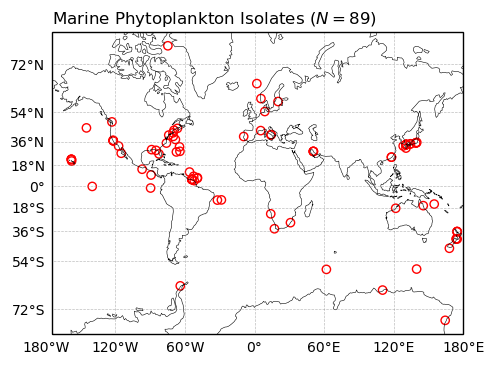

In [6]:
fig = plt.figure(dpi=100)
ax = plt.axes(projection=_PROJECTION)
ax.scatter(
    plankton['isolation.longitude'],
    plankton['isolation.latitude'],
    transform = ccrs.PlateCarree(), 
    facecolor='none', edgecolors='r'
)
ax.add_feature(cf.COASTLINE, linewidth=0.4)
util.add_gridlines(ax)

plt.title(f"Marine Phytoplankton Isolates ($N = {len(plankton)}$)", loc='left');
plt.savefig("figures/marine_phyto_isolates.png", dpi=300, bbox_inches='tight')

### Latitudinal Modeling

As mentioned above, I derive latitudinal models of $T_\mathrm{opt}$, $T_\mathrm{min}$, and $T_\mathrm{max}$ from these data. More detail can be found in [another notebook](./physiology/TPC_params_latitudinal_generalization.ipynb). I summarise the shape of these curves below: 

In [95]:
topt_colname = 'mu.g.opt.list' ## 29) mu.g.opt.list = estimated optimum temperature for growth 
tmin_colname = 'tmin'
tmax_colname = 'tmax'

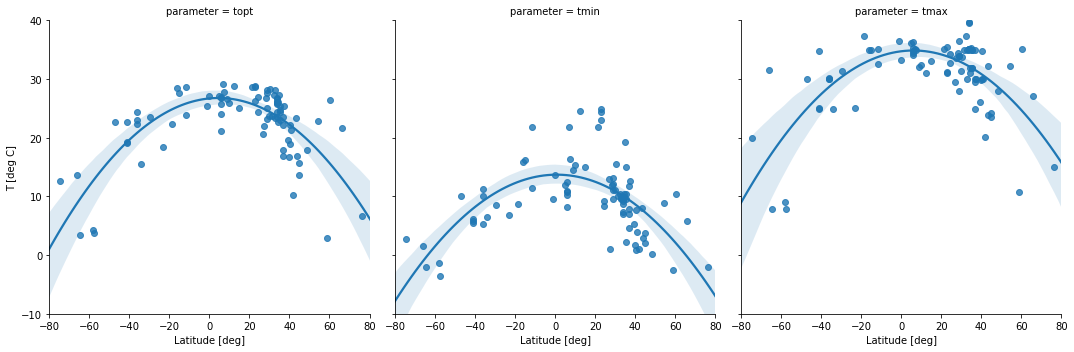

In [115]:
lat_df_plotting = pd.melt(
    id_vars=['isolation.latitude', 'group'], 
    value_vars=[topt_colname, tmin_colname, tmax_colname],
    frame=plankton
).rename(axis=1, mapper = {
    'variable' : 'parameter', 
}).replace({
    'mu.g.opt.list' : 'topt'
})
with warnings.catch_warnings():
    warnings.simplefilter('ignore');
    f = sns.lmplot(
        x = 'isolation.latitude', 
        y = 'value', 
        col = 'parameter',
        col_wrap=3, 
        data = lat_df_plotting,
        order=2, size=5
    )
    f.set_axis_labels(x_var = "Latitude [deg]", y_var = "T [deg C]")
    [(_.set_xlim([-80, 80]), _.set_ylim([-10, 40])) for _ in f.axes];

Finer details of these fits are [here](./physiology/TPC_params_latitudinal_generalization.ipynb). 

**It is worth noting** that these relationships differ significantly by functional groups, as demonstrated in the figure below from Thomas et al., 2016: 


For now we generailize across groups, but this will likely change in the future. 



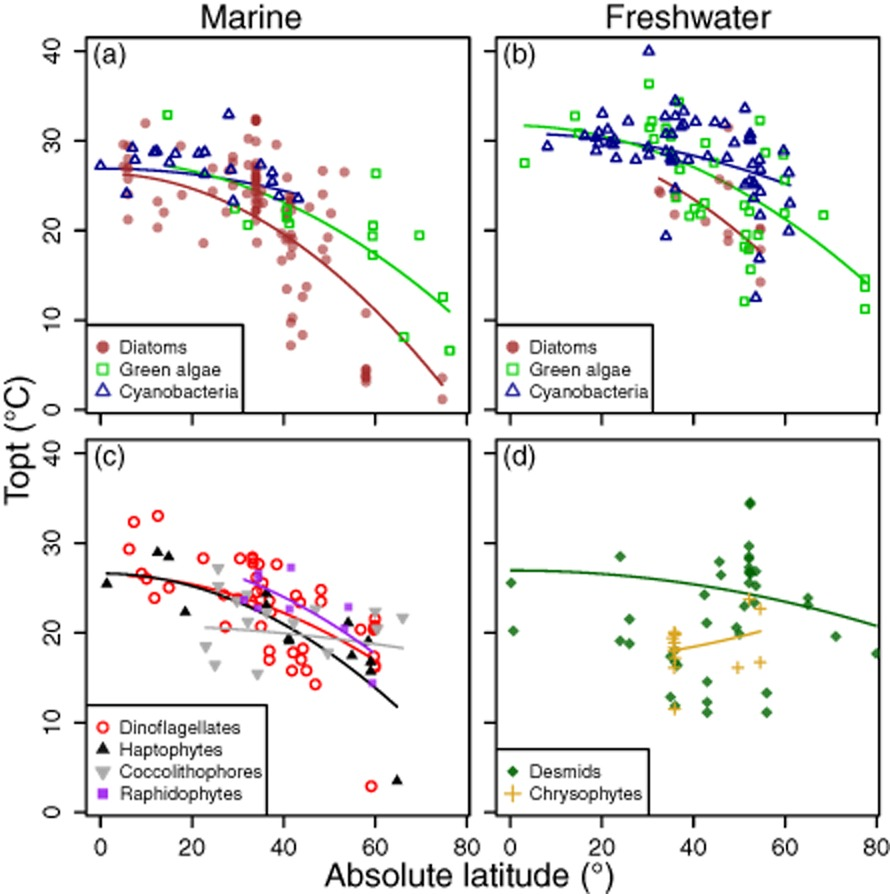

### Latitudinally-Generalized Reaction Norm Function
We use the fitted relationships above to parameterize the reaction norm function presented in Deutsch et al., 2008, which constructs a thermal performance curve by combining a gaussian function to describe the rise in performance up to the optimal temperature with a quadratic decline to zero performance at critical thermal maxima and higher temperatures. This procedure is described [here](./physiology/TPC_params_latitudinal_generalization.ipynb). **Again, as above, it is worth noting** that there are reasons to generalize on **both latitude and functional group**, but this initial analysis does not do this. Below we will load the latitudinally-parameterized function. 

In [89]:
with open("./physiology/gtpc_modeled.pkl", 'rb') as f:
    gtpc = cloudpickle.load(f)
[_ for _ in dir(gtpc) if not _.startswith('__')]

['getLatitudinalTPC',
 'getTPCParameters',
 'tmaxModel',
 'tminModel',
 'toptModel']

An example curve for latitude = 45:

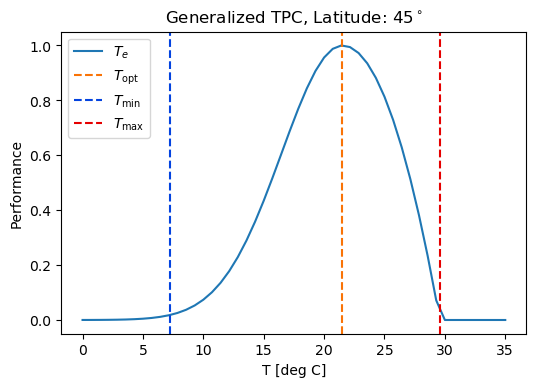

In [94]:
latitude = 45
topt, tmin, tmax = gtpc.getTPCParameters(latitude)
tpc = gtpc.getLatitudinalTPC(latitude)

plt.figure(dpi=100)
T = np.linspace(0, 35)
T_e = tpc(T)

plt.plot(T, T_e, label=R'$T_e$')
plt.axvline(topt, color='xkcd:orange', linestyle='--', label=r'$T_\mathrm{opt}$')
plt.axvline(tmin, color='xkcd:blue', linestyle='--', label=r'$T_\mathrm{min}$')
plt.axvline(tmax, color='xkcd:red', linestyle='--', label=r'$T_\mathrm{max}$')
plt.legend()
plt.xlabel("T [deg C]")
plt.ylabel("Performance")
plt.title(f"Generalized TPC, Latitude: ${latitude}^\circ$");

## Applying Generalized TPC Function to Marine Heatwave Periods

I use the above generalized TPC, applied latitudinally to a 1/4 degree daily historical (1981-Present) sea surface temperature dataset, to compute daily performance in each grid cell. 

I use codes from Oliver et al., 2018 to detect marine heatwaves in this SST record. I then use these detections to filter the SST record to only those periods containing marine heatwaves. I then explore the relationship between the following performance metrics and marine heatwave decriptive parameters, such as intensity and duration ($P = $ performance from generalized TPC): 

* Performance Detriment: $$P_\textrm{det}(T) = 1 - P(T)$$
* Performance Difference ($\textrm{w.r.t}$ seasonal climatology): $$P_\textrm{diff}(T, \textrm{time}) = P(T) - P(T_\textrm{clim | time})$$
* Performance Ratio ($\textrm{w.r.t}$ seasonal climatology): $$P_\textrm{ratio}(T, \textrm{time}) = \frac{P(T)}{P(T_\textrm{clim | time})}$$

Detailed computation of performance latitutinally can be seen [here](./TPC_lat_generalization_model_SST.ipynb). We load the results below for the **North Pacific** region.

In [118]:
performance = xr.open_dataset("pnw_performance.nc")
performance

<xarray.Dataset>
Dimensions:           (lat: 120, lon: 140, time: 13636)
Coordinates:
  * lat               (lat) float32 30.125 30.375 30.625 ... 59.625 59.875
  * lon               (lon) float32 -155.875 -155.625 ... -121.375 -121.125
  * time              (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31
Data variables:
    performance       (time, lat, lon) float32 ...
    performance_clim  (time, lat, lon) float32 ...
    topt              (time, lat, lon) float32 ...
    tmin              (time, lat, lon) float32 ...
    tmax              (time, lat, lon) float32 ...

We merge these data with detections of marine heatwaves as follows (computed [elsewhere](../mhw_pipeline/oisst-mhw-clean.ipynb)).

In [121]:
awsfs = s3fs.S3FileSystem()
mhw_mapper = s3fs.S3Map("s3://mhw-stress/new_with_climatology", s3=awsfs)
mhws = xr.open_zarr(mhw_mapper, consolidated=True)
mhws = mhws.chunk({
    'lat': 100, 
    'lon' : 100, 
    'time': 500
})

Text(0.5, 1.0, 'All Time MHWs, N.Pacific')

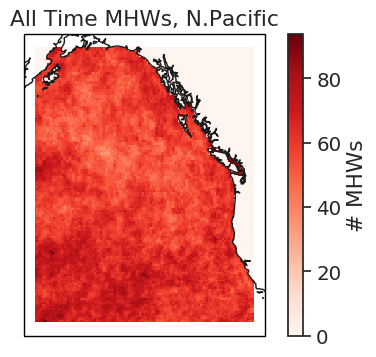

In [148]:
fig = plt.figure(dpi=100)
ax = plt.axes(projection=_PROJECTION)
mhws.mhw.max(dim='time').plot.pcolormesh(ax=ax, cmap='Reds', transform=ccrs.PlateCarree(), cbar_kwargs=dict(label='# MHWs'))
ax.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k')
plt.title("All Time MHWs, N.Pacific")

I choose "significant" marine heatwave events of longer than 20 days after 2000. 

In [123]:
DURATION_THRESHOLD = 20
mhw_only_filter = (mhws.mhw !=0) & (mhws.duration >= DURATION_THRESHOLD)

In [126]:
performance_merged = xr.merge([performance, mhws], join='inner')
performance_mhw = performance_merged.where(mhw_only_filter & (performance_merged.time.dt.year > 2000), drop=True)

I then compute the performance metrics as above (~5 minutes). **Since we have time series data for each MHW event at each grid-cell, we have to aggregate somehow over time**. The methods used here are fairily evident below. 

In [127]:
pf_ddf = performance_mhw.to_dask_dataframe()
def compute_mhw_performance(df):
    return pd.Series({
        'detriment_sum' : (1 - df.performance).sum(),
        'detriment_mean' : (1 - df.performance).mean(),
        'performance_diff_sum' : (df.performance - df.performance_clim).sum(),
        'performance_ratio_mean' : (df.performance / df.performance_clim).mean(),
        'intensity_cumulative' : df.intensity_cumulative.min(),
        'duration' : df.duration.min(),
        'start_doy' : df.time.dt.dayofyear.min(),
        'perf_det_ratio' : ((1-df.performance) / (1-df.performance_clim)).mean()
    })
mhw_perf = pf_ddf.groupby(['lat', 'lon', 'mhw']).apply(compute_mhw_performance).compute()

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  del sys.path[0]


In [128]:
mhw_perf = mhw_perf.reset_index()

mhw_perf['latitude_bin'] = pd.cut(mhw_perf['lat'], 20)

Text(0.0, 1, 'Performance during MHW Events')

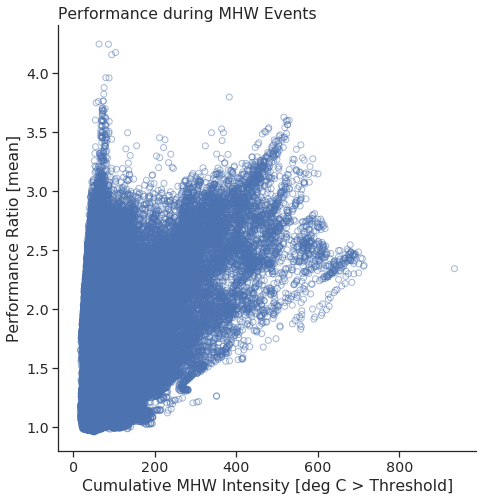

In [149]:
sns.set(style='ticks', font_scale=1.3)
fg = sns.lmplot(
    x = 'intensity_cumulative',
    y = 'performance_ratio_mean', 
    height=7,data=mhw_perf, 
    fit_reg=False,
    scatter_kws=dict(facecolors='none', alpha=0.5, label='MHW Event')
)

fg.set_axis_labels(x_var = 'Cumulative MHW Intensity [deg C > Threshold]', y_var = 'Performance Ratio [mean]')
plt.title("Performance during MHW Events", loc='left')

A performance ratio > 1 indicates that performance at that time (with real-time SST) is *greater* than the performance computed for the seasonal climatology at that same time point. The above plot demonstrates that all MHWs in the North Pacific Region lead to improved performance. 

This finding suggests that at all points during marine heatwaves in this region, the temperature is less than the latitudinally-modeled $T_\mathrm{opt}$. 

This led us to investigate the relationship **between $T_\mathrm{opt}$ and mean/max SST**, both for the individual isolates in the Thomas et al. 2012 data and in our modeled generalization. 

## $T_\mathrm{opt}$ Exceedance Frequencies

The issue of the relationship between $T_\mathrm{opt}$ and mean temperature is one investigated in the original Thomas et al 2012 article (Figure 2): 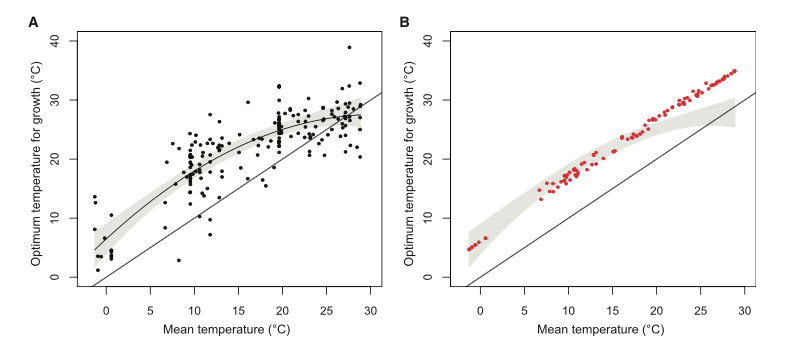

In almost all cases, the species observed in this dataset have thermal optima that is considerably higher than the environmental mean temperature, and is well-correlated, suggesting adaptation. I wanted to use the SST data we have to explore the frequency with which the environmental temperature exceeds or nears thermal optima, both for individual speices and for our modeled $T_\mathrm{opt}$. 

### Species-level $T_\mathrm{opt}$ Exceedances

I begin with the species within the Thomas data set, and compute exceedances within the grid-cell nearest each isolate for the full (1981-Present) OISST dataset. 

In [152]:
exceedance_count = []
for _i, species in plankton.iterrows():
    lat = species['isolation.latitude']
    lon = species['isolation.longitude']
    
    _sst = oisst.sel(lat = lat, lon = lon, method='nearest', tolerance = 0.5) # SST within 0.5 deg

    exceedance_count.append((_sst.sst > species[topt_colname]).astype('int').sum())

exceedances = dask_client.compute(exceedance_count, sync=True, optimize_graph=True)

In [156]:
plankton['topt_exceedances'] = list(map(np.asscalar, exceedances))
plankton['topt_exceedances_pct'] = plankton.topt_exceedances / len(oisst.time)
plankton['latbins'] = pd.cut(plankton['isolation.latitude'], bins=20)

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, '$T_\\mathrm{opt}$ SST Exceedances')

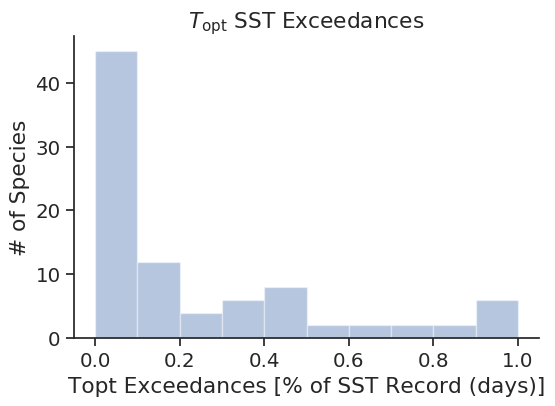

In [161]:
plt.figure(dpi=100)
sns.distplot(plankton['topt_exceedances_pct'], kde=False, bins=10)
plt.xlabel("Topt Exceedances [% of SST Record (days)]")
plt.ylabel("# of Species")
sns.despine()
plt.title("$T_\mathrm{opt}$ SST Exceedances")

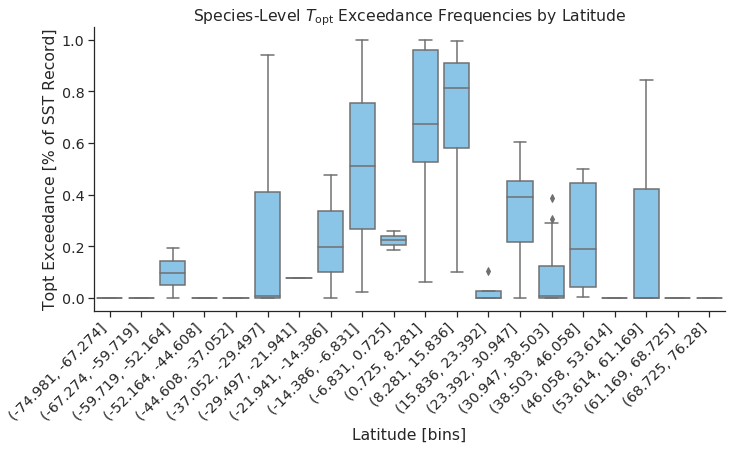

In [179]:
sns.catplot(x = 'latbins', y = 'topt_exceedances_pct', estimator = np.mean, kind='box', data=plankton, color='xkcd:lightblue', aspect=2.1)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Latitude [bins]")
plt.ylabel("Topt Exceedance [% of SST Record]");
plt.title("Species-Level $T_\mathrm{opt}$ Exceedance Frequencies by Latitude");

We can see here that SST is exceeding thermal optima fairly frequently for many of the species in this dataset. This leads us to wonder whether there are temporal dynamics at play here -- for example, exceeding thermal optima isn't relevant if the species is otherwise not present in that location at that time, for other reasons. It is likely incorrect to use *the entire SST record* to compute Topt exceedances. 

It's likely wise to complte this analysis with an eye toward seasonality. Below we copy a plot from [another notebook](/physiology/Topt_exceedances.ipynb), which is identical to the above plot but computes exceedance percentages within each season. That is, for all of the "December, January, February" data present in the historical (1981-Present) data, what is the percentage of these SST values that exceed thermal optima? 

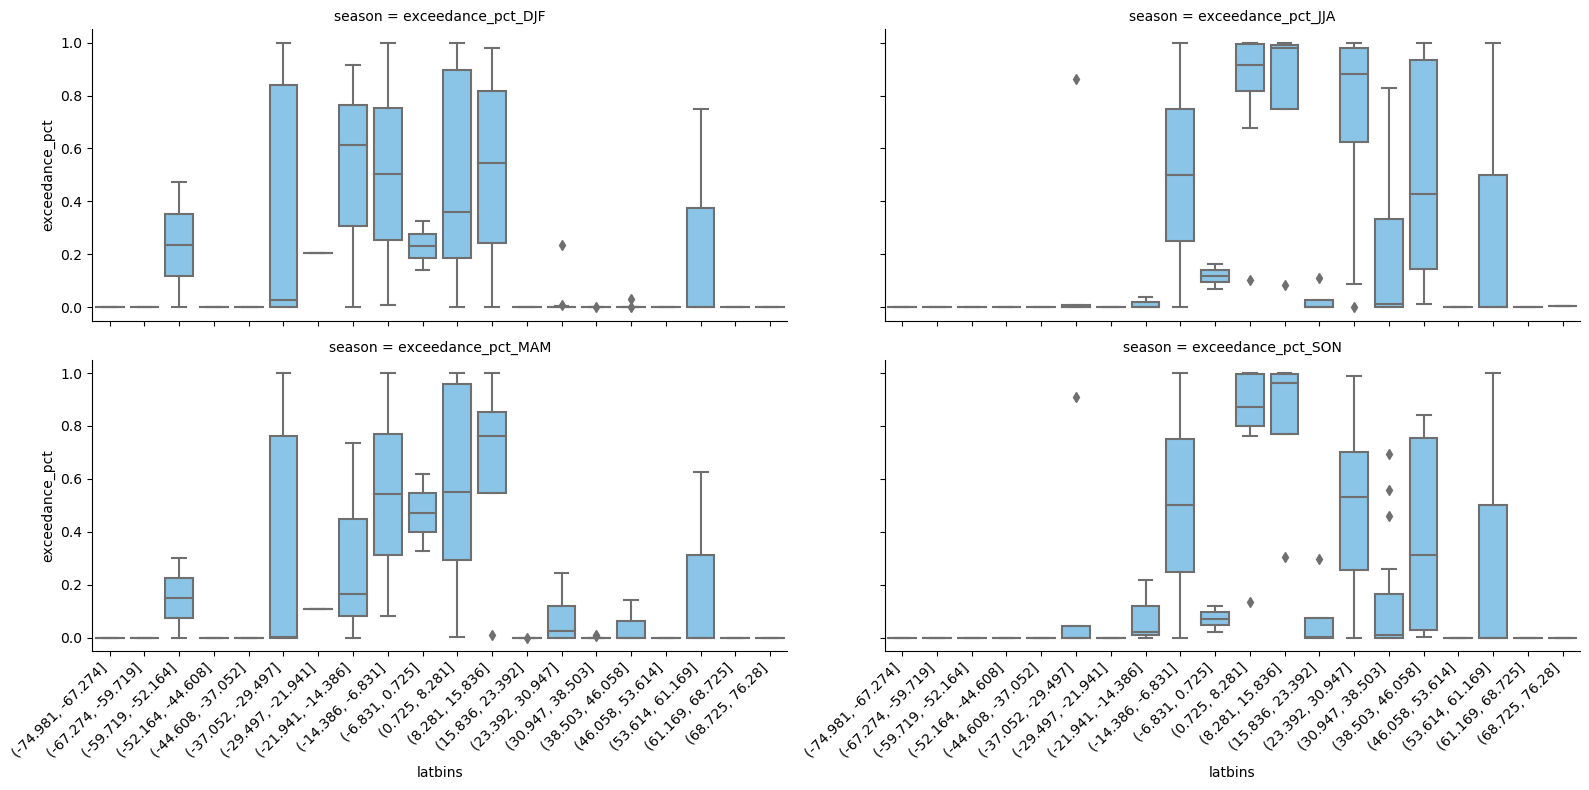

We look next at the *percentage of the species in a given latitude* that have seen their thermal optima exceeded in more than 40% of the record. 


In [202]:
lat_exceedances = plankton.groupby('latbins').apply(lambda x: np.sum((x.topt_exceedances_pct > 0.4)) / len(x)).rename("species_04_exceedance_pct").reset_index()

In [219]:
lat_group_sizes = plankton.groupby('latbins').count().reset_index()

(0, 1)

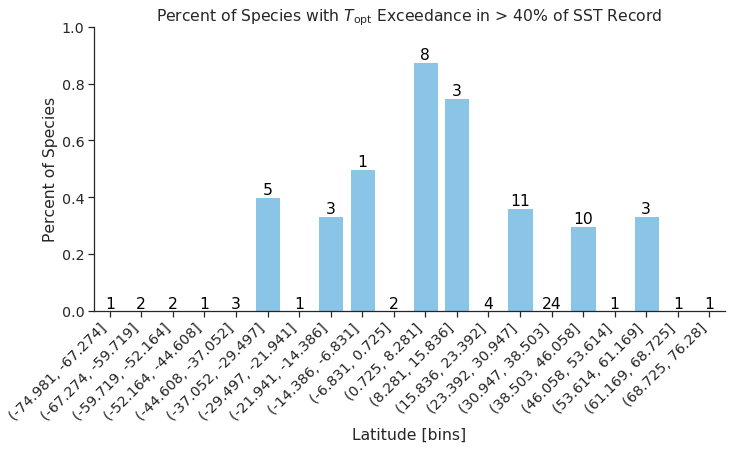

In [225]:
fg = sns.catplot(x = 'latbins', y='species_04_exceedance_pct', data=lat_exceedances, kind='bar', aspect=2.1, color='xkcd:lightblue')
plt.xticks(rotation=45, ha='right');

for index, row in lat_exceedances.iterrows():

    plt.text(index, row['species_04_exceedance_pct'] + 0.01, lat_group_sizes.loc[index].source, color='black', ha="center")

plt.title("Percent of Species with $T_\mathrm{opt}$ Exceedance in > 40% of SST Record")
plt.xlabel("Latitude [bins]")
plt.ylabel("Percent of Species")
plt.ylim([0, 1])

We can see here that the **equatorial region** has a high percentage of species exceeding their thermal optima in greater than 40% of the SST record. 

### Modeled $T_\mathrm{opt}$ Exceedances by Region

Circling back to the above observation that all of the Marine heatwaves observed in the Northern Pacific subregion studied exhibit *improved* phytoplankton performance, thus suggesting temperatures below our modeled thermal optima, we examine this question explicitly: how often is temperature below modeled thermal optima in this northern pacific region? 

In [227]:
databounds = {
    'lat': slice(performance.lat.min(), performance.lat.max()),
    'lon': slice(performance.lon.min(), performance.lon.max()),
}
these_sst = oisst.sel(**databounds)

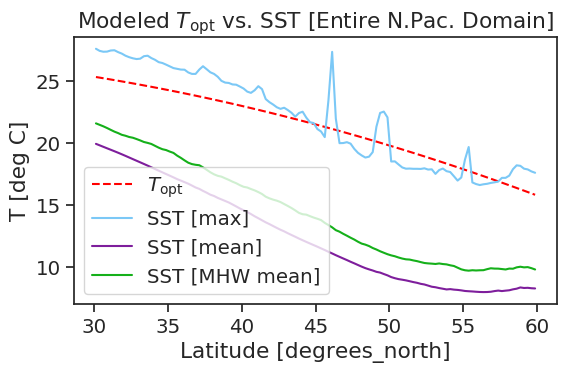

In [233]:
plt.figure(dpi=100)
ax = plt.axes()
performance.topt.max(dim=['lon', 'time']).plot(label='$T_\mathrm{opt}$', ax=ax, color='red', linestyle='--')
these_sst.sst.max(dim=['lon', 'time']).plot(ax=ax, color='xkcd:lightblue', label='SST [max]')
these_sst.sst.mean(dim=['lon', 'time']).plot(ax=ax, color='xkcd:purple', label='SST [mean]')
these_sst.where(mhw_only_filter).sst.mean(dim=['lon', 'time']).plot(ax=ax, color='xkcd:green', label='SST [MHW mean]')
ax.set_ylabel("T [deg C]")
plt.title("Modeled $T_\mathrm{opt}$ vs. SST [Entire N.Pac. Domain]")
plt.legend()

We can see from this plot that even during MHW times (green line) the temperature is quite far from the modeled thermal optima in this region.

## Next Steps

We intend to continue investigating the impact of marine heatwaves on phytoplankton from a thermal physiology perspective. From both the results outlined in prior work and some preliminary investigations above, we have the following next steps:

1. Expand this analysis geographically to examine whether the different relationships between thermal optima and SST in other regions may lead to differing regimes of thermal performance during marine heatwave events 
1. Explore a thermal reaction norm generalization procedure that is parameterized on both latitude and functional group to capture some of the differences in latitudinal responses between functional groups.
1. In contrast to latitudinal extrapolation, explore whether individual species' modeled reaction norms (from Thomas et al. 2012) can be used directly in their specific geographic regions to more confidently understand the relationship between MHW anomalies and performance. 